In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
labels = ['NORMAL','PNEUMONIA']
img_size = 80
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                img_arr = cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
                img_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                img_arr = img_arr/255.0
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data('/content/gdrive/MyDrive/chest_xray/train')
test = get_training_data('/content/gdrive/MyDrive/chest_xray/test')
val = get_training_data('/content/gdrive/MyDrive/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [5]:
def generate_x_y_train_test(arr):
  x = []
  y = []
  for i in range(len(arr)):
    x.append(arr[i][0])
    y.append(arr[i][1])
  return np.array(x),np.array(y)

In [6]:
x_train, y_train = generate_x_y_train_test(train)
x_test, y_test = generate_x_y_train_test(test)
x_val, y_val = generate_x_y_train_test(val)

In [7]:
x = np.concatenate([x_train,x_test,x_val],axis=0)
x.shape

(5856, 80, 80, 3)

In [8]:
y = np.concatenate([y_train,y_test,y_val],axis=0)
y.shape

(5856,)

In [9]:
pd.value_counts(y)

1    4273
0    1583
dtype: int64

In [10]:
x_train, x_test2, y_train, y_test2 = train_test_split(x, y, test_size=0.30, random_state=44, shuffle =True)
x_val, x_test, y_val, y_test = train_test_split(x_test2, y_test2, test_size=0.50, random_state=44, shuffle =True)
print('X_train shape is ' , x_train.shape)
print('X_val shape is ' , x_val.shape)
print('X_test shape is ' , x_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_val shape is ' , y_val.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4099, 80, 80, 3)
X_val shape is  (878, 80, 80, 3)
X_test shape is  (879, 80, 80, 3)
y_train shape is  (4099,)
y_val shape is  (878,)
y_test shape is  (879,)


In [11]:
pd.value_counts(y_train)

1    2988
0    1111
dtype: int64

In [12]:
pd.value_counts(y_val)

1    635
0    243
dtype: int64

In [13]:
pd.value_counts(y_test)

1    650
0    229
dtype: int64

In [15]:
# Load the model
generator = load_model('generator-1000.h5')

In [16]:
2988-1111

1877

In [17]:
x_gen_normal = []
y_gen_normal = np.zeros(1877,dtype = int)
for i in range(1877):
  noise = np.random.normal(0,1,size = (1,100))
  gen_img = generator.predict(noise)
  gen_img = gen_img.reshape(150,150)
  gen_img = cv2.cvtColor(gen_img,cv2.COLOR_BGR2RGB)
  gen_img = cv2.resize(gen_img,(80,80))
  x_gen_normal.append(gen_img)

1/1 [==============================] - 0s 18ms/step


In [18]:
x_gen_normal = np.array(x_gen_normal)
x_gen_normal.shape

(1877, 80, 80, 3)

In [19]:
y_gen_normal.shape

(1877,)

In [20]:
x_train = np.concatenate([x_train, x_gen_normal],axis=0)
y_train = np.concatenate([y_train, y_gen_normal],axis=0)
x_train.shape,y_train.shape

((5976, 80, 80, 3), (5976,))

In [21]:
pd.value_counts(y_train)

1    2988
0    2988
dtype: int64

In [22]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(img_size,img_size,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 78, 78, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                        

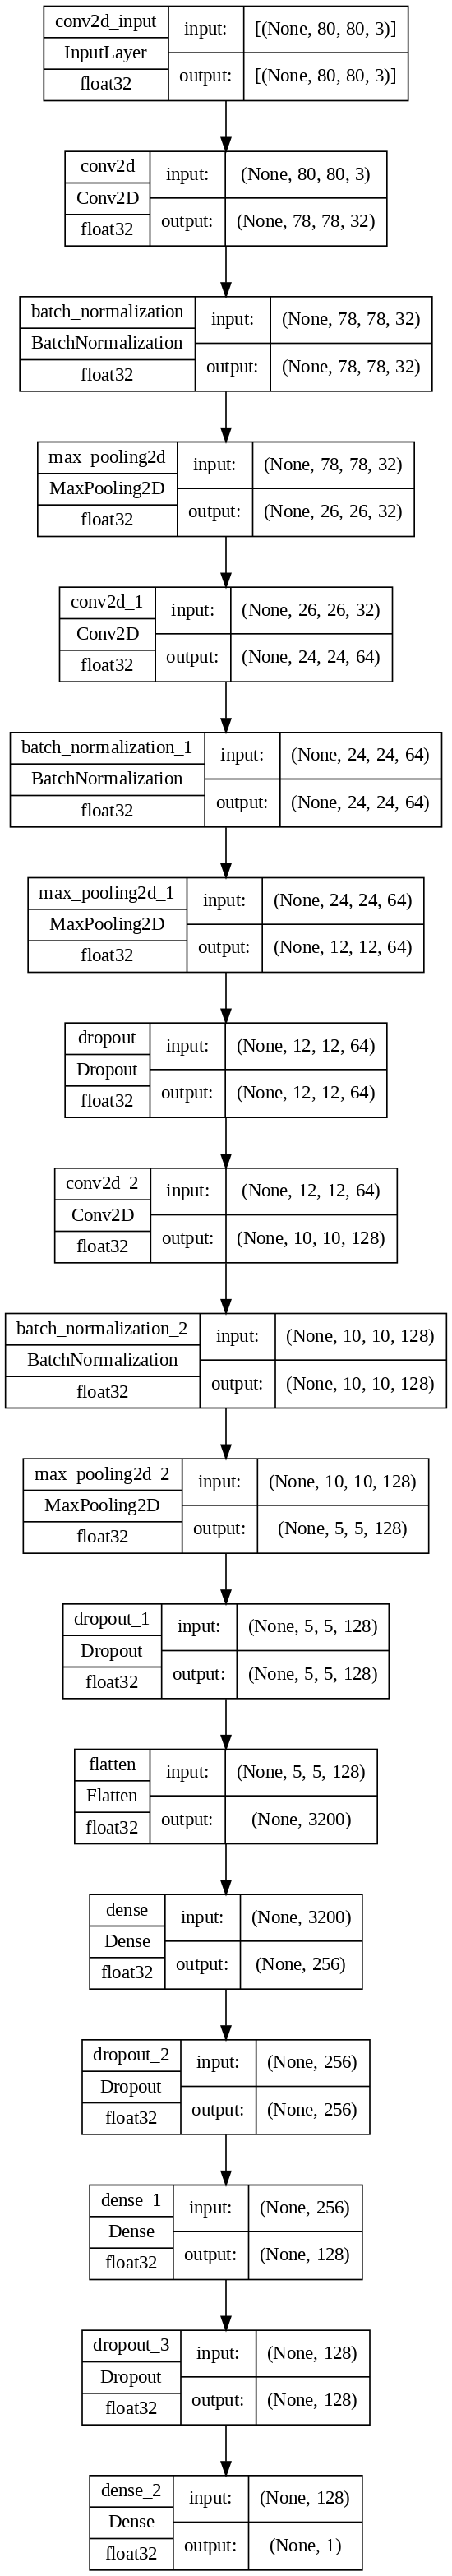

In [24]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [25]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit(x_train,y_train,epochs=20,validation_data=(x_val,y_val),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
187/187 [==============================] - 10s 16ms/step - loss: 0.2788 - accuracy: 0.9096 - val_loss: 3.1149 - val_accuracy: 0.7232
Epoch 2/20
187/187 [==============================] - 2s 12ms/step - loss: 0.1366 - accuracy: 0.9531 - val_loss: 4.5445 - val_accuracy: 0.7232
Epoch 3/20
187/187 [==============================] - 2s 13ms/step - loss: 0.1178 - accuracy: 0.9600 - val_loss: 0.7376 - val_accuracy: 0.7961
Epoch 4/20
187/187 [==============================] - 2s 12ms/step - loss: 0.1050 - accuracy: 0.9647 - val_loss: 0.2750 - val_accuracy: 0.9077
Epoch 5/20
187/187 [==============================] - 3s 15ms/step - loss: 0.1071 - accuracy: 0.9639 - val_loss: 0.1746 - val_accuracy: 0.9431
Epoch 6/20
187/187 [==============================] - 2s 13ms/step - loss: 0.0926 - accuracy: 0.9702 - val_loss: 0.1754 - val_accuracy: 0.9351
Epoch 7/20
187/187 [==============================] - 2s 12ms/step - loss: 0.0857 - accuracy: 0.9694 - val_loss: 0.2521 - val_accuracy: 0.907

In [26]:
score, acc = model.evaluate(x_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

28/28 [==============================] - 0s 12ms/step - loss: 0.1215 - accuracy: 0.9579
Test Loss = 0.12146878987550735
Test Accuracy = 0.9579067230224609


In [27]:
score, acc = model.evaluate(x_train,y_train)
print('Train Loss =', score)
print('Train Accuracy =', acc)

187/187 [==============================] - 1s 5ms/step - loss: 0.0422 - accuracy: 0.9866
Train Loss = 0.042249493300914764
Train Accuracy = 0.9866130948066711


In [28]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.278797,0.909639,3.114857,0.723235
1,0.136578,0.953146,4.544493,0.723235
2,0.117785,0.960007,0.737637,0.796128
3,0.105016,0.964692,0.275027,0.907745
4,0.107066,0.963855,0.174564,0.943052
5,0.092585,0.970214,0.175422,0.935080
6,0.085721,0.969378,0.252121,0.907745
7,0.079297,0.968541,0.895913,0.683371
8,0.070125,0.975904,0.157084,0.949886
9,0.063817,0.976071,0.316712,0.879271


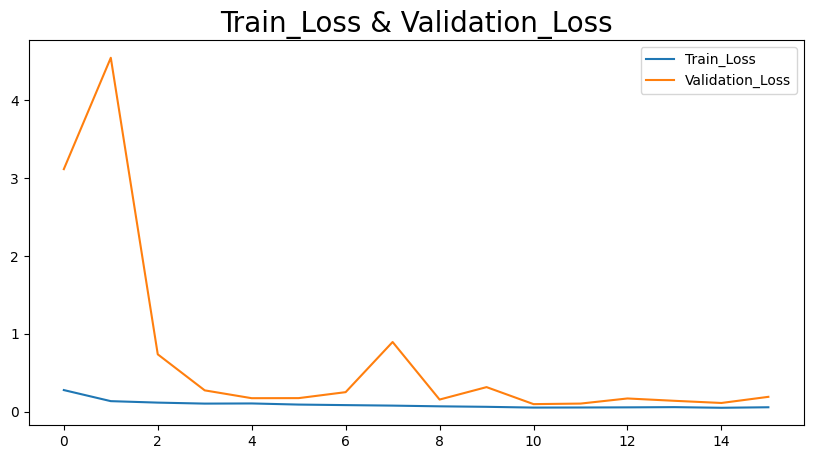

In [34]:
plt.figure(figsize=(10,5))
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.savefig('basCNN_train_val_loss.png')

In [33]:
plt.savefig('basCNN_train_val_loss.png')

<Figure size 640x480 with 0 Axes>

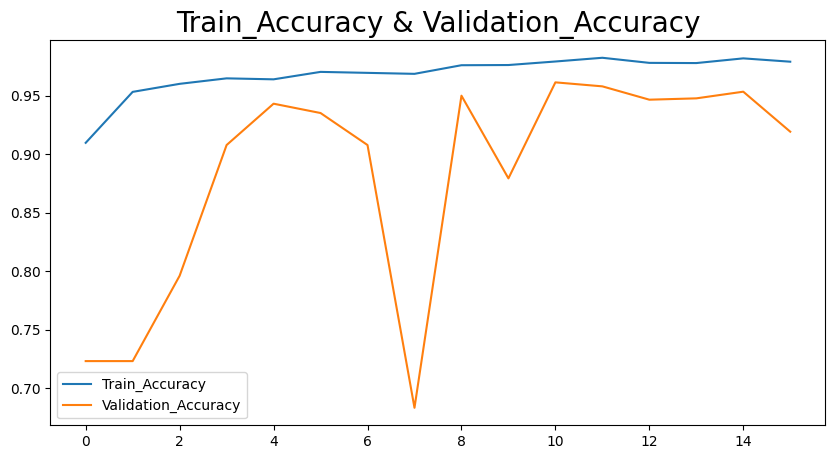

In [35]:
plt.figure(figsize=(10,5))
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.savefig('basCNN_train_val_acc.png')

In [36]:
prediction = model.predict(x_test)
prediction[0]

28/28 [==============================] - 0s 3ms/step


array([0.01456654], dtype=float32)

In [37]:
print([labels[i] for i in y_test])

['NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL

In [47]:
y_pred[0][0]

0

In [49]:
for j in range(len(y_pred)):
  print(labels[y_pred[j][0]])

NORMAL
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
NORMAL
NORMAL
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
NORMAL
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
PNEUMONIA
PNEUMONIA
NORMAL
PNEUMO

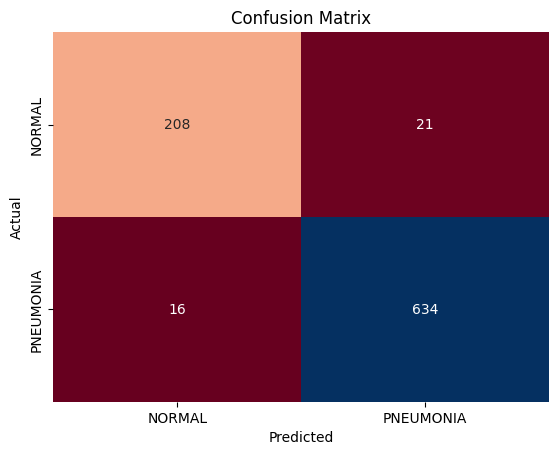

<Figure size 640x480 with 0 Axes>

In [60]:
y_pred=np.where(prediction>=.5,1,0)
ax= plt.subplot()
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM, annot=True, fmt='g', xticklabels = labels, yticklabels=labels, ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()
CM
plt.savefig('basCNN_cm')

In [64]:
ClassificationReport = classification_report(y_test,y_pred)
print('\nClassification Report:\n', ClassificationReport)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       229
           1       0.97      0.98      0.97       650

    accuracy                           0.96       879
   macro avg       0.95      0.94      0.94       879
weighted avg       0.96      0.96      0.96       879



In [65]:
# Transfer Learning Model

In [66]:
base_model = tf.keras.applications.VGG16(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_tr=keras.models.Sequential()
model_tr.add(base_model)
model_tr.add(keras.layers.Flatten())
model_tr.add(keras.layers.Dropout(.5))
model_tr.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model_tr.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 14716737 (56.14 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


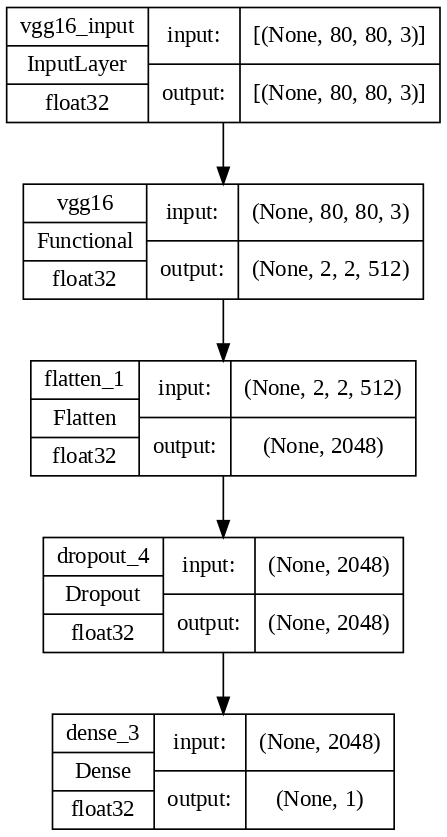

In [67]:
tf.keras.utils.plot_model(model_tr, to_file='model2.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [68]:
checkpoint_cb =ModelCheckpoint("my_keras_model2.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model_tr.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=model_tr.fit(x_train,y_train,epochs=20,validation_data=(x_val,y_val),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
187/187 [==============================] - 9s 38ms/step - loss: 0.4060 - accuracy: 0.8312 - val_loss: 0.2835 - val_accuracy: 0.9100
Epoch 2/20
187/187 [==============================] - 6s 32ms/step - loss: 0.2245 - accuracy: 0.9290 - val_loss: 0.2404 - val_accuracy: 0.9169
Epoch 3/20
187/187 [==============================] - 5s 29ms/step - loss: 0.1908 - accuracy: 0.9359 - val_loss: 0.2310 - val_accuracy: 0.9226
Epoch 4/20
187/187 [==============================] - 6s 33ms/step - loss: 0.1767 - accuracy: 0.9389 - val_loss: 0.2091 - val_accuracy: 0.9294
Epoch 5/20
187/187 [==============================] - 5s 28ms/step - loss: 0.1657 - accuracy: 0.9448 - val_loss: 0.2141 - val_accuracy: 0.9282
Epoch 6/20
187/187 [==============================] - 5s 29ms/step - loss: 0.1521 - accuracy: 0.9496 - val_loss: 0.2074 - val_accuracy: 0.9305
Epoch 7/20
187/187 [==============================] - 6s 31ms/step - loss: 0.1566 - accuracy: 0.9456 - val_loss: 0.1971 - val_accuracy: 0.9362

In [69]:
score, acc = model_tr.evaluate(x_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

28/28 [==============================] - 1s 45ms/step - loss: 0.1893 - accuracy: 0.9272
Test Loss = 0.18934546411037445
Test Accuracy = 0.9271900057792664


In [72]:
score, acc = model_tr.evaluate(x_train,y_train)
print('Train Loss =', score)
print('Train Accuracy =', acc)

187/187 [==============================] - 5s 25ms/step - loss: 0.0975 - accuracy: 0.9675
Train Loss = 0.09752357006072998
Train Accuracy = 0.9675368070602417


In [73]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.406028,0.831158,0.283505,0.910023
1,0.224458,0.929050,0.240436,0.916856
2,0.190841,0.935910,0.231015,0.922551
3,0.176651,0.938922,0.209127,0.929385
4,0.165653,0.944779,0.214080,0.928246
5,0.152128,0.949632,0.207381,0.930524
6,0.156575,0.945616,0.197084,0.936219
7,0.150886,0.944946,0.194259,0.936219
8,0.143487,0.947456,0.201493,0.929385
9,0.140890,0.951640,0.185979,0.937358


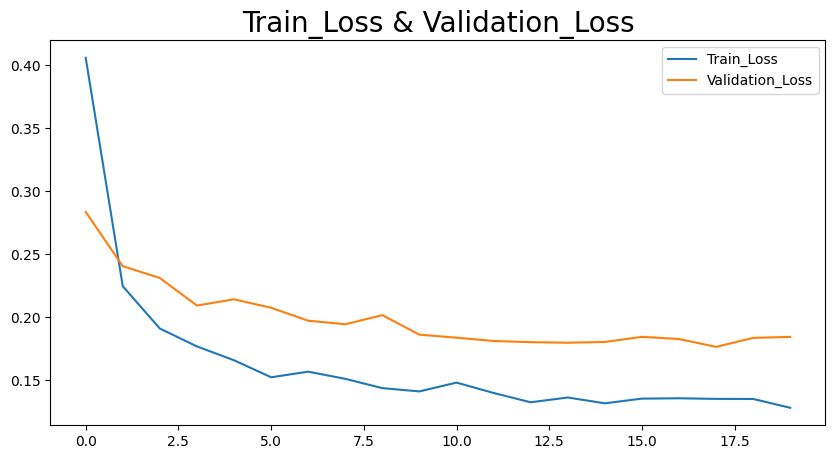

In [75]:
plt.figure(figsize=(10,5))
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.savefig('VGG16_train_val_loss.png')

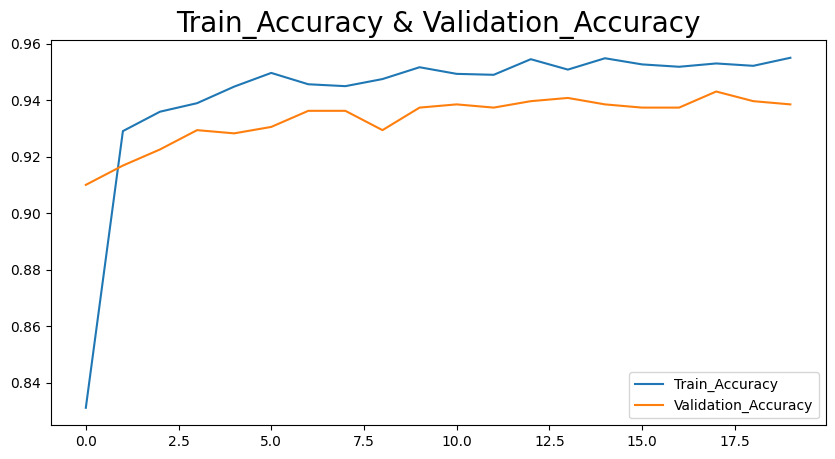

In [76]:
plt.figure(figsize=(10,5))
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.savefig('VGG16_train_val_acc.png')

In [77]:
prediction = model_tr.predict(x_test)
prediction[0]

28/28 [==============================] - 1s 25ms/step


array([0.04237738], dtype=float32)

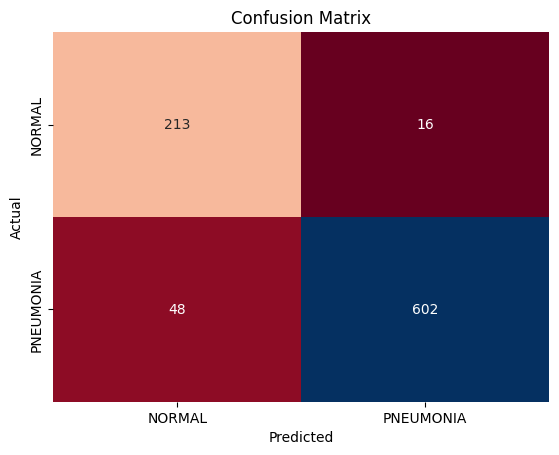

array([[213,  16],
       [ 48, 602]])

<Figure size 640x480 with 0 Axes>

In [80]:
y_pred=np.where(prediction>=.5,1,0)
ax= plt.subplot()
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM, annot=True, fmt='g', xticklabels = labels, yticklabels=labels,ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()
plt.savefig('VGG16_cm.png')
CM

In [81]:
ClassificationReport = classification_report(y_test,y_pred)
print('\nClassification Report:\n', ClassificationReport)


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       229
           1       0.97      0.93      0.95       650

    accuracy                           0.93       879
   macro avg       0.90      0.93      0.91       879
weighted avg       0.93      0.93      0.93       879



In [93]:
type(x_gen_normal)

numpy.ndarray

In [94]:
np.save('gen_imgs_np_values',x_gen_normal)

In [96]:
a = np.load('/content/gen_imgs_np_values.npy')
a.shape

(1877, 80, 80, 3)

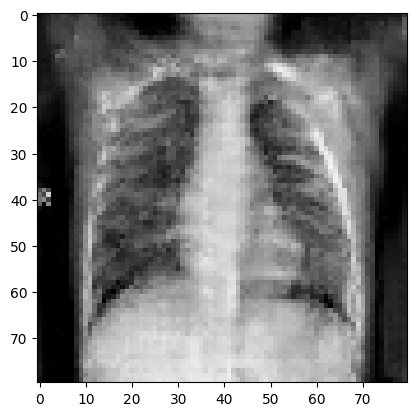

In [97]:
plt.imshow(a[0])